In [8]:
import time
from cs336_scaling.common import (
    get_chinchilla_n_for_c,
    get_chinchilla_lr_for_n,
    power_law,
)

from cs336_scaling.constants import FLOPS_BUDGET
from cs336_scaling.training_api import sync_api_state, get_total_flops_used
from cs336_scaling.analyze import (
    best_run_where,
    fit_quadratic,
    find_optimal_params,
    plot_runs,
    get_all_runs,
    plot_loss_vs_lr_at_c_and_n,
    group_by,
    plot_tokens_per_param_vs_loss,
    best_lr_per_n,
)

from scipy.optimize import curve_fit
import numpy as np

In [2]:
def print_flops_stats(total_flops_used: float | None = None):
    if total_flops_used is None:
        total_flops_used = get_total_flops_used()

    print(f"Total FLOPs Used: {total_flops_used:.2e}")
    print(f"Total FLOPs Used (%): {total_flops_used * 100 / FLOPS_BUDGET:.3f}")
    print("-" * 100)


def print_stats_at_c(
    c: float,
    all_runs: list[dict] | None = None,
    best_n: int | None = None,
    sync_api: bool = False,
    best_lr_per_n: bool = True,
):
    if all_runs is None and sync_api is False:
        raise ValueError("Must provide either all_runs or sync_api")

    if sync_api:
        all_runs, total_flops_used = sync_api_state()

    runs_at_c = [run for run in all_runs if run["train_flops"] == c]

    if len(runs_at_c) == 0:
        print(f"No runs found for C = {c:.0e}")
        return

    runs_to_fit = runs_at_c

    if best_lr_per_n:
        group_by_n = group_by(runs_at_c, "est_n_non_embedding")
        for n in group_by_n:
            group_by_n[n] = sorted(group_by_n[n], key=lambda x: x["loss"])[0]

        runs_to_fit = list(group_by_n.values())

    if best_n is not None:
        runs_to_fit = sorted(runs_at_c, key=lambda x: x["loss"])[:best_n]

    fit_fn = fit_quadratic(runs_to_fit)
    coeffs = fit_fn.coeffs
    best_run = min(runs_at_c, key=lambda x: x["loss"])
    best_run_n = best_run["est_n_non_embedding"]
    best_run_n_total = best_run["est_n_total"]
    chinchilla_lr = get_chinchilla_lr_for_n(best_run_n_total)
    pred_opt_n = find_optimal_params(fit_fn)
    pred_opt_loss = fit_fn(np.log(pred_opt_n))

    print(f"Best for C = {c:.0e}:")

    print(f"- Non-embedding params: {best_run_n:.2e} ({best_run_n} params)")
    print(f"- LR: {best_run['learning_rate']:.3e} (chinchilla: {chinchilla_lr:.3e})")
    print(f"- Loss: {best_run['loss']:.5f}")
    print(f"- Total params: {best_run_n_total:.2e} ({best_run_n_total} params)")
    print(f"- Embedding ratio: {best_run['est_embed_ratio']:.2f}")
    print(
        f"- Tokens: {best_run['est_tokens']:.2e} ({int(best_run['est_tokens'])} tokens)"
    )
    print(f"- Tokens per param (D/N): {best_run['est_tokens_per_param']:.3f}")
    print(f"- Aspect ratio: {best_run['d_model'] / best_run['num_layers']:.2f}")
    print(best_run)
    print("-" * 100)

    print(f"Quadratic fit for all runs at {c:.0e} FLOPs:")
    print(f"{coeffs[0]:.4f}x^2 + {coeffs[1]:.4f}x + {coeffs[2]:.4f}")

    print(f"Pred. optimal params: {pred_opt_n:.2e}")
    print(f"Pred. loss at optimal params: {pred_opt_loss:.5f}")

    print("-" * 100)

In [5]:
# NEW LR LAW IMPLIED BY BEST LR AT SOME OTHER SCALE
C_1 = 1e16
C_2 = 3e16
C_3 = 1e17

best_run = best_run_where("train_flops", C_2)

print(f"Best run LR: {best_run['learning_rate']:.3e}")
print(f"Best run N_total: {best_run['est_n_total']:.2e} ({best_run['est_n_total']:,})")

def get_lr(n_total):
	return best_run["learning_rate"] * (n_total / best_run["est_n_total"])**-0.2

print(get_lr(1.18e7))
print(get_lr(1e8)) # 100M
print(get_lr(4e8)) # 400M
print(get_lr(1e9)) # 1B

Best run LR: 5.023e-04
Best run N_total: 2.79e+07 (27,852,800)
0.0005964279056188331
0.00038898634532031305
0.0002947965238741665
0.00024543379148236015


In [6]:
# NEW TOTAL PARAMS EST. IF MATCHING BEST TOKENS/PARAM AT DIFF. SCALE

best_run = best_run_where("train_flops", C_2)

print(f"Tokens/param: {best_run['est_tokens_per_param']:.2f}")

def get_n_total(c):
  return get_chinchilla_n_for_c(c, tokens_per_param=best_run['est_tokens_per_param'])

print(f"Empirical N_total at 1e16: {get_n_total(C_2):.2e} ({get_n_total(C_2):,})")
print(f"N_total at 1e17: {get_n_total(1e17):.2e} ({get_n_total(1e17):,})")
print(f"N_total at 1e18: {get_n_total(1e18):.2e} ({get_n_total(1e18):,})")
print(f"N_total at 1e19: {get_n_total(1e19):.2e} ({get_n_total(1e19):,})")
print(f"N_total at 1e20: {get_n_total(1e20):.2e} ({get_n_total(1e20):,})")


Tokens/param: 6.45
Empirical N_total at 1e16: 2.79e+07 (27,852,799)
N_total at 1e17: 5.09e+07 (50,852,022)
N_total at 1e18: 1.61e+08 (160,808,215)
N_total at 1e19: 5.09e+08 (508,520,228)
N_total at 1e20: 1.61e+09 (1,608,082,157)


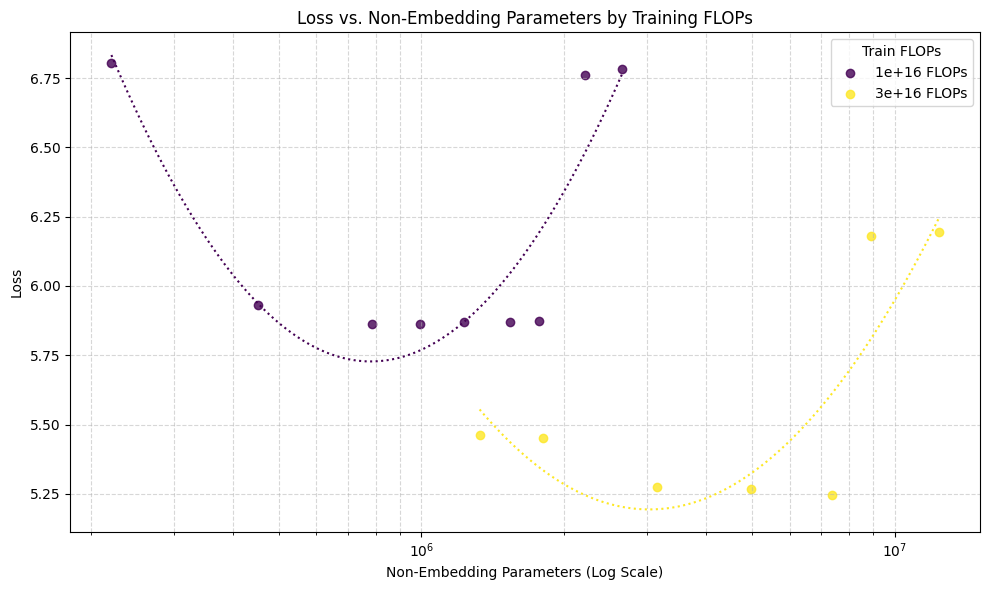

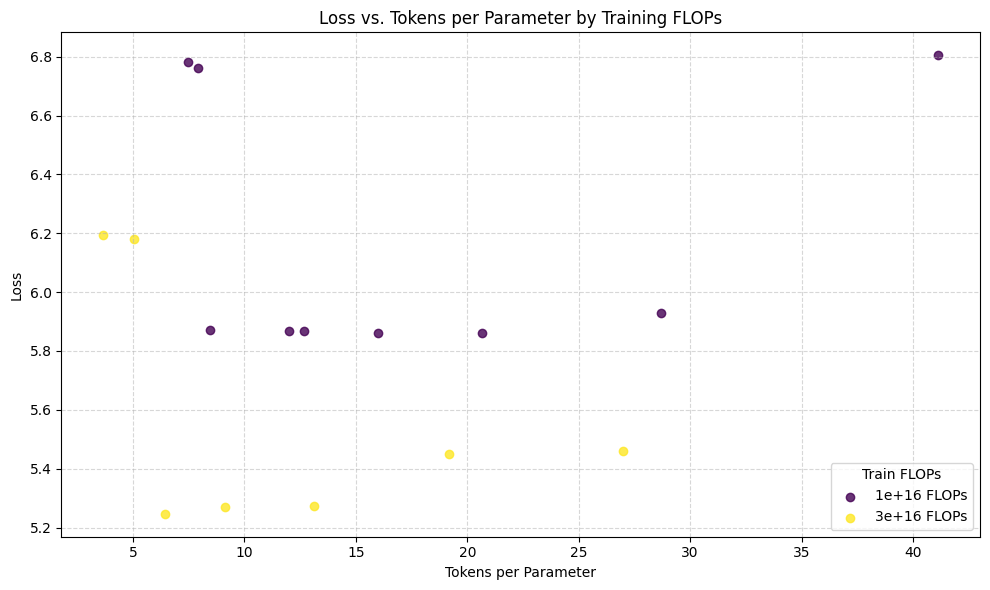

In [16]:
runs = get_all_runs()
runs = [run for run in runs if run["train_flops"] >= 1e16]
plot_runs(runs, best_n_per_c=10)
plot_tokens_per_param_vs_loss(runs, best_n_per_c=10)

In [11]:
def fit_power_law(c_to_n_opt: dict[float, int]) -> tuple[float, float]:
    """Fits a power law N = a * C^b to the optimal parameter data."""
    budgets = sorted(list(c_to_n_opt.keys()))
    x = np.array(budgets)
    y = np.array([c_to_n_opt[b] for b in budgets])

    # Set initial guess for exponent = 0.5 based on Hoffman et. al
    popt, _ = curve_fit(power_law, x, y)
    return tuple(popt)

In [12]:
all_runs = get_all_runs()
runs_1e16 = best_lr_per_n([run for run in all_runs if run["train_flops"] == 1e16])
runs_3e16 = best_lr_per_n([run for run in all_runs if run["train_flops"] == 3e16])

fit_1e16 = fit_quadratic(runs_1e16)
fit_3e16 = fit_quadratic(runs_3e16)

opt_params_1e16 = int(find_optimal_params(fit_1e16))
opt_params_3e16 = int(find_optimal_params(fit_3e16))

opt_loss_1e16 = fit_1e16(np.log(opt_params_1e16))
opt_loss_3e16 = fit_3e16(np.log(opt_params_3e16))

print(f"Optimal N (non-embedding) at 1e16: {opt_params_1e16:.2e} ({opt_params_1e16:,})")
print(f"Optimal N (non-embedding) at 3e16: {opt_params_3e16:.2e} ({opt_params_3e16:,})")

print(f"Optimal loss at 1e16: {opt_loss_1e16:.5f}")
print(f"Optimal loss at 3e16: {opt_loss_3e16:.5f}")

c_to_n_opt = {
    1e16: opt_params_1e16,
    3e16: opt_params_3e16,
}

a, b = fit_power_law(c_to_n_opt)
print(f"Power law: N = {a:.2e} * C^{b:.2f}")

for c in [1e16, 3e16, 1e17, 1e18, 1e19, 1e20]:
    pred_opt_n = int(power_law(c, a, b))
    print(f"Predicted optimal N at {c:.2e}: {pred_opt_n:.2e} ({pred_opt_n:,})")

Optimal N (non-embedding) at 1e16: 7.82e+05 (781,575)
Optimal N (non-embedding) at 3e16: 3.03e+06 (3,029,877)
Optimal loss at 1e16: 5.72761
Optimal loss at 3e16: 5.19385
Power law: N = 1.44e-14 * C^1.23
Predicted optimal N at 1.00e+16: 7.82e+05 (781,575)
Predicted optimal N at 3.00e+16: 3.03e+06 (3,029,877)
Predicted optimal N at 1.00e+17: 1.34e+07 (13,375,623)
Predicted optimal N at 1.00e+18: 2.29e+08 (228,906,123)
Predicted optimal N at 1.00e+19: 3.92e+09 (3,917,425,873)
Predicted optimal N at 1.00e+20: 6.70e+10 (67,041,568,039)


/var/folders/rf/hpfv3sm53bx8r7lfnyh2mws80000gn/T/ipykernel_15337/1835677398.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(power_law, x, y)


In [ ]:
import matplotlib.pyplot as plt

runs = get_all_runs()
runs = [run for run in runs if run["train_flops"] == 3e16]

runs = group_by(runs, "est_n_non_embedding")

plt.figure(figsize=(10, 6))

n_values = sorted(runs.keys())
colors = plt.cm.viridis(np.linspace(0, 1, len(n_values)))

for i, n in enumerate(n_values):
    runs_for_n = runs[n]
    learning_rates = [run["learning_rate"] for run in runs_for_n]
    losses = [run["loss"] for run in runs_for_n]
    label = f"N={n} ({len(runs_for_n)} runs)"
    plt.scatter(learning_rates, losses, color=colors[i], label=label, alpha=0.8)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs. Learning Rate for Different N")
plt.legend()
plt.show()

In [9]:
from cs336_scaling.training_api import get_total_flops_used

print(get_total_flops_used())

4.769e+17
